**Objective:**

Develop a model which takes any screenshot as input and identifies the content visible on the screen.


The model should then generate a natural language understanding of what is present in the screenshot.


You may preprocess the image as you see fit and use techniques like optical character recognition to detect the text in the image.
You are free to use any other approach to your imagination.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp '/content/drive/MyDrive/Kaggle/kaggle.json' '/content'   #renew json file

In [3]:

import zipfile
import os

os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [4]:
!kaggle datasets download -d adityajn105/flickr30k

100% 8.14G/8.16G [01:25<00:00, 122MB/s]
100% 8.16G/8.16G [01:25<00:00, 102MB/s]


In [5]:
zip_ref = zipfile.ZipFile('/content/flickr30k.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/content') #Extracts the files into the /content folder
zip_ref.close()

In [6]:
import numpy as np
import pandas as pd
import os
import re
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [7]:
image_path = '/content/Images'

In [8]:
data = pd.read_csv("/content/captions.txt")
data.head()

image                                            caption
0  1000092795.jpg   Two young guys with shaggy hair look at their...
1  1000092795.jpg   Two young , White males are outside near many...
2  1000092795.jpg   Two men in green shirts are standing in a yard .
3  1000092795.jpg       A man in a blue shirt standing in a garden .
4  1000092795.jpg            Two friends enjoy time spent together .

# Method - 1

### Using deep learning model to predict caption of the image.

In [9]:
import pandas as pd

data = pd.read_csv("/content/captions.txt")

# Shuffle the data randomly
data = data.sample(frac=1, random_state=42)

#can change this according to what we want
unique_images = data['image'].unique()[:]

# Filter the data to keep only rows for the selected images
data = data[data['image'].isin(unique_images)]

# Ensure each image has 1 caption
data = data.groupby('image').head(1)

# Check the dataframe size
print(f"Number of images: {data['image'].nunique()}")
print(f"Number of captions: {len(data)}")

# Display a few rows
data.head(6)


Number of images: 31783
Number of captions: 31783


image                                            caption
138302  5797756884.jpg   A man is sitting on an upturned white bucket ...
1325     109260218.jpg   Spelunkers pose inside a rock cavern while ba...
130789  5087543347.jpg             A toddler enjoying her birthday cake .
101814   450596617.jpg              Two people are walking by the ocean .
22387    226481576.jpg   Young , smiling , blond female police officer...
132175  5214515583.jpg   Three men wearing leather apparel performing ...

### Data Visualisation

In [31]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.

    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(10):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"/content/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

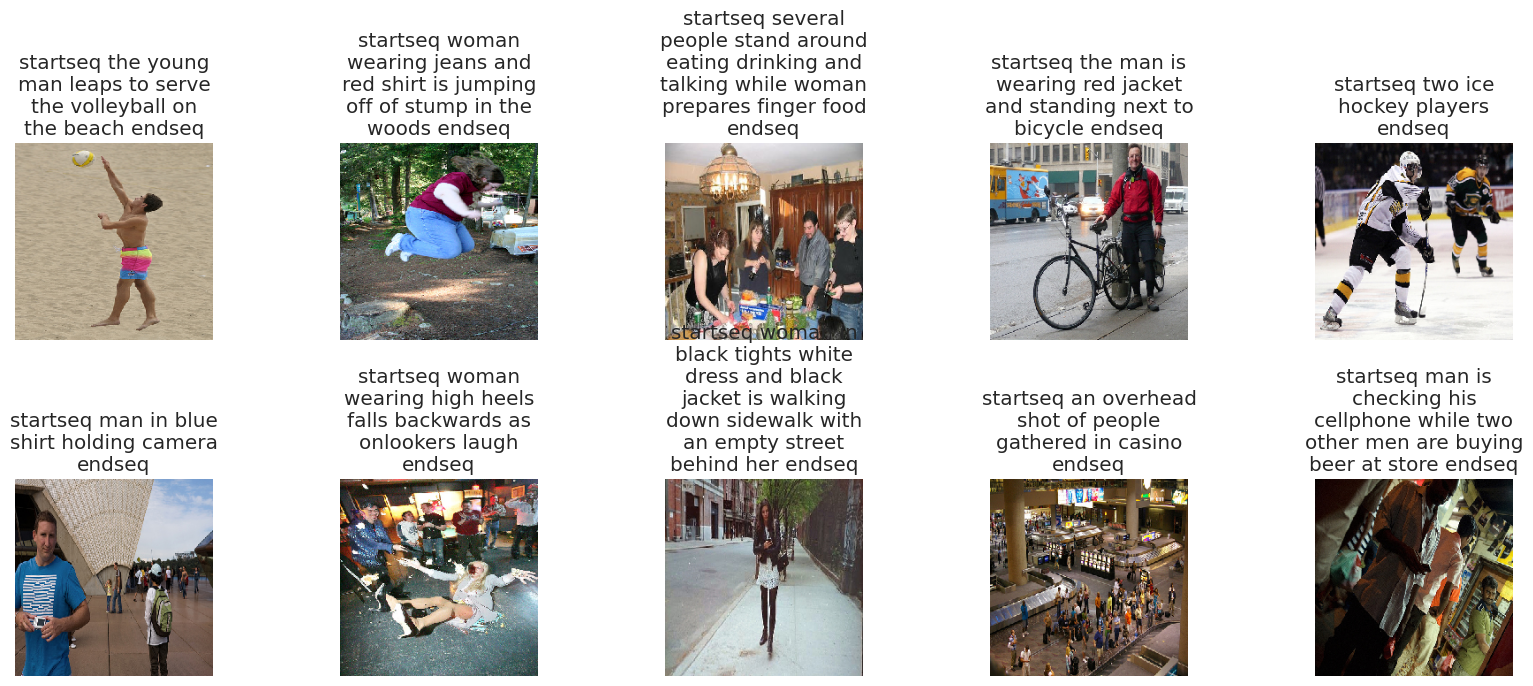

In [43]:
display_images(data.sample(10, random_state=42))

### **Caption Text Preprocessing Steps**



*   Convert sentences into lowercase
*   Remove special characters and numbers present in the text
*   Remove extra spaces
*   Remove single characters
*   Add a starting and an ending tag to the sentences to indicate the beginning and the ending of a sentence











In [16]:
import re

def text_preprocessing(data):
    # Ensure text type:
    data['caption'] = data['caption'].astype(str)  # Convert to string if necessary

    # Lowercase:
    data['caption'] = data['caption'].apply(lambda x: x.lower())

    # Handle numbers, punctuation, and whitespace:
    data['caption'] = data['caption'].apply(lambda x: re.sub(r"[^a-z\s]", " ", x))
    data['caption'] = data['caption'].apply(lambda x: re.sub(r"\s+", " ", x))

    # Keep words with length > 1:
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word) > 1]))

    # Add start and end sequences:
    data['caption'] = "startseq " + data['caption'] + " endseq"

    return data


In [17]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq man is sitting on an upturned white bucket playing banjo endseq',
 'startseq spelunkers pose inside rock cavern while bathed in sunlight from the surface endseq',
 'startseq toddler enjoying her birthday cake endseq',
 'startseq two people are walking by the ocean endseq',
 'startseq young smiling blond female police officer from new york standing outside on sidewalk endseq',
 'startseq three men wearing leather apparel performing in concert two singing with microphones and the center artist playing the electric guitar with lights shining on them with large screen images behind them and drum set in the background endseq',
 'startseq child reaches the bottom of an inflatable slide endseq',
 'startseq woman getting styling cut from female hair stylist endseq',
 'startseq two men performing piece of music one in plaid shirt singing into microphone and the other in all black strumming an acoustic guitar endseq',
 'startseq young blond girl wearing pink is lying on tile floor loo

In [18]:

# Initialize a tokenizer
tokenizer = Tokenizer()

# Fit the tokenizer on the captions to create a vocabulary
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size (plus 1 for the zero-padding)

# Determine the maximum length of a caption
max_length = max(len(caption.split()) for caption in captions)

# Get unique image names
images = data['image'].unique().tolist()
nimages = len(images)



# Split the data into training and validation sets
split_index = round(0.75 * nimages)
train_images = images[:split_index]
val_images = images[split_index:]

# Create training and validation sets
train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

# Reset the index of the training and validation sets
train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

# Convert a sample caption to a sequence of integers using the tokenizer
sample_caption = captions[1]
sequence = tokenizer.texts_to_sequences([sample_caption])[0]


In [31]:
import os
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)
image_folder = '/content/Images/'  # Replace this with the correct path
data['image_path'] = data['image'].apply(lambda x: os.path.join(image_folder, x))  # New column to hold full image paths

img_size = 224
features = {}
for index, row in tqdm(data.iterrows(), total=len(data)):
    image_path = row['image_path']
    img = load_img(image_path, target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.
    img = np.expand_dims(img, axis=0)
    feature = fe.predict(img, verbose=0)
    features[row['image']] = feature  # Store feature with the image name as key


100%|██████████| 31783/31783 [1:06:30<00:00,  7.97it/s]


In [10]:
import pickle

In [12]:
with open('/content/drive/MyDrive/movie/features.pkl', 'rb') as file:
    features = pickle.load(file)

In [15]:
features

{'5797756884.jpg': array([[1.7539888e-04, 1.0836853e-03, 1.1082488e-03, ..., 4.4951066e-01,
         7.9769009e-01, 1.1684012e-01]], dtype=float32),
 '109260218.jpg': array([[1.08146705e-04, 8.20638263e-04, 2.01423792e-03, ...,
         3.62805240e-02, 1.99720478e+00, 3.39648628e+00]], dtype=float32),
 '5087543347.jpg': array([[3.2663840e-05, 8.5174834e-04, 6.9922564e-04, ..., 3.1118102e+00,
         4.1914719e-01, 2.4273133e+00]], dtype=float32),
 '450596617.jpg': array([[1.6169759e-04, 9.4671076e-04, 1.3724718e-03, ..., 1.9168086e-01,
         1.2975134e+00, 1.8386927e+00]], dtype=float32),
 '226481576.jpg': array([[1.5790205e-04, 8.8595046e-04, 3.2698980e-04, ..., 1.5443034e+00,
         1.3827753e+00, 1.8776143e-01]], dtype=float32),
 '5214515583.jpg': array([[1.5769397e-04, 6.1600341e-04, 1.3915428e-03, ..., 6.0895467e-01,
         4.1589499e+00, 1.2046365e+00]], dtype=float32),
 '2643263887.jpg': array([[1.6567974e-04, 5.6950940e-04, 8.0555334e-04, ..., 5.7165164e-01,
         1.

In [13]:
class CustomDataGenerator(Sequence):

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features,shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self, index):
      batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size, :]
      X1, X2, y = self.__get_data(batch)

      return (X1, X2), y

    def __get_data(self,batch):

        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()

        for image in images:
          if image in self.features:

            feature = self.features[image][0]

            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]

                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)


        return X1, X2, y

In [19]:
from keras.layers import LSTM, Bidirectional, Dense, Add


# Input layers for image features and captions
input1 = Input(shape=(1920,))         # Image features input
input2 = Input(shape=(max_length,))   # Captions input

# Image features processing
img_features = Dense(512, activation='relu')(input1)
img_features_reshaped = Reshape((1, 512), input_shape=(512,))(img_features)


# Captions processing
sentence_features = Embedding(vocab_size, 512, mask_zero=False)(input2)

#size should be same

# Concatenate image and sentence features
merged = concatenate([img_features_reshaped,sentence_features],axis=1)

# Bidirectional LSTM layer for sentence processing
sentence_features = Bidirectional(LSTM(256))(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [20]:

caption_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 1920)]               0         []                            
                                                                                                  
 dense (Dense)               (None, 512)                  983552    ['input_2[0][0]']             
                                                                                                  
 input_3 (InputLayer)        [(None, 59)]                 0         []                            
                                                                                                  
 reshape (Reshape)           (None, 1, 512)               0         ['dense[0][0]']               
                                                                                              

In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenizing the captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['caption'])  # Fit tokenizer on training captions

# Convert text captions to sequences of integers
train_sequences = tokenizer.texts_to_sequences(train['caption'])
test_sequences = tokenizer.texts_to_sequences(test['caption'])

# Padding sequences to a maximum length
max_caption_length = max(len(seq) for seq in train_sequences + test_sequences)
train_captions = pad_sequences(train_sequences, maxlen=max_caption_length, padding='post')
test_captions = pad_sequences(test_sequences, maxlen=max_caption_length, padding='post')

train_generator = CustomDataGenerator(
    df=train,
    X_col='image',
    y_col='caption',
    batch_size=128,
    directory=image_path,
    tokenizer=tokenizer,  # Pass the tokenizer
    vocab_size=vocab_size,  # Define vocab_size
    max_length=max_caption_length,  # Use the maximum caption length
    features=features  # Assuming features contain image embeddings
)

validation_generator = CustomDataGenerator(
    df=test,
    X_col='image',
    y_col='caption',
    batch_size=128,
    directory=image_path,
    tokenizer=tokenizer,
    vocab_size=vocab_size,
    max_length=max_caption_length,
    features=features
)


In [22]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only=True,
                            verbose=1)

early_stopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.0000001)



In [23]:
# Compile and train the model
history = caption_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint, early_stopping, learning_rate_reduction]
)

Epoch 1/30
186/186 [==============================] - ETA: 0s - loss: 6.0985
Epoch 1: val_loss improved from inf to 5.32780, saving model to model.h5
186/186 [==============================] - 91s 440ms/step - loss: 6.0985 - val_loss: 5.3278 - lr: 0.0010
Epoch 2/30
186/186 [==============================] - ETA: 0s - loss: 5.2377
Epoch 2: val_loss improved from 5.32780 to 4.83977, saving model to model.h5
186/186 [==============================] - 83s 446ms/step - loss: 5.2377 - val_loss: 4.8398 - lr: 0.0010
Epoch 3/30
186/186 [==============================] - ETA: 0s - loss: 4.8985
Epoch 3: val_loss improved from 4.83977 to 4.62085, saving model to model.h5
186/186 [==============================] - 76s 404ms/step - loss: 4.8985 - val_loss: 4.6208 - lr: 0.0010
Epoch 4/30
186/186 [==============================] - ETA: 0s - loss: 4.6908
Epoch 4: val_loss improved from 4.62085 to 4.47733, saving model to model.h5
186/186 [==============================] - 76s 406ms/step - loss: 4.6908 

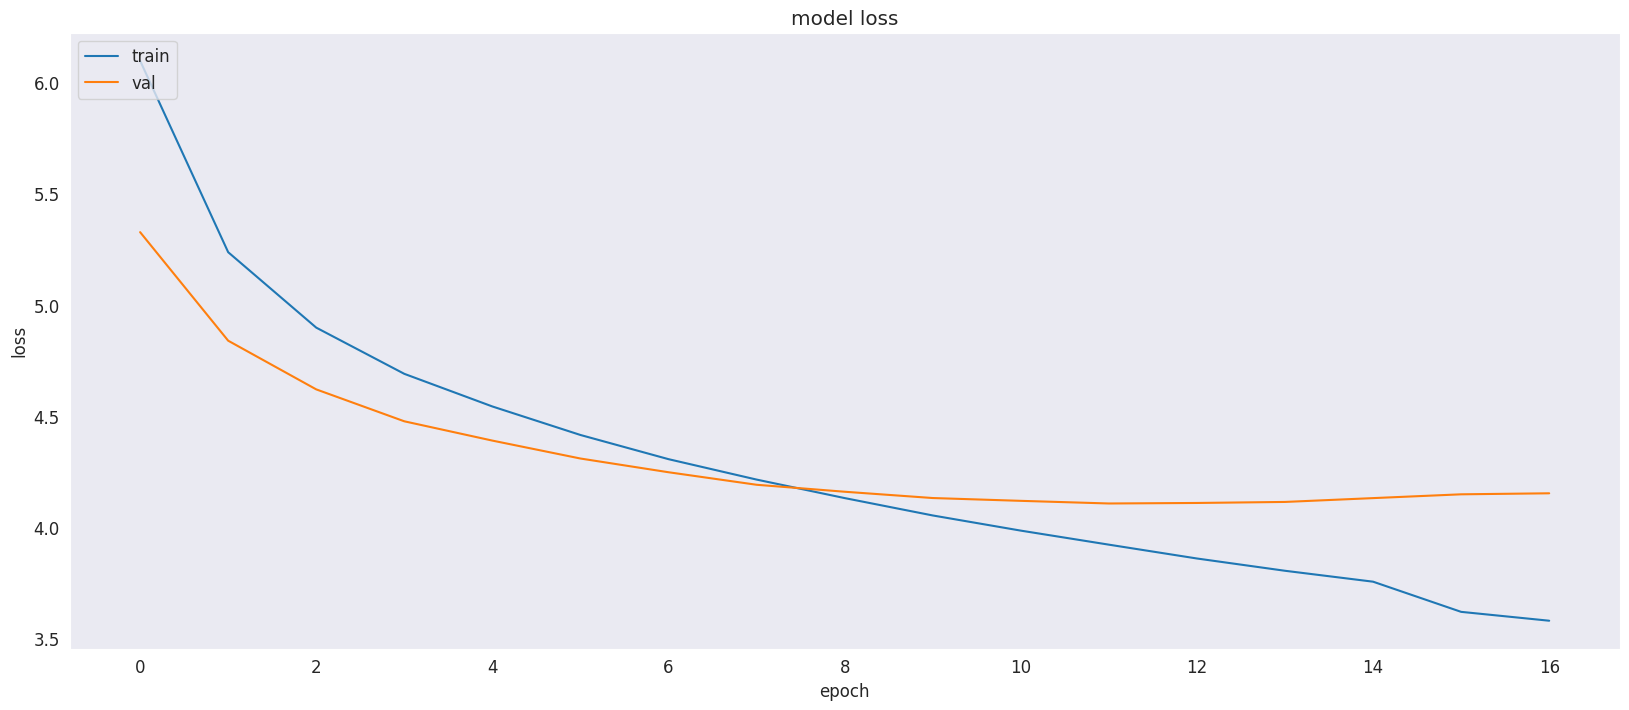

In [24]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Testing our Predictions

In [25]:
def idx_to_word(integer,tokenizer):

    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [26]:
def predict_caption(model, image, tokenizer, max_length, features):

    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)

        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break

        in_text+= " " + word

        if word == 'endseq':
            break

    return in_text

In [27]:
samples = test.sample(10)
samples.reset_index(drop=True,inplace=True)

In [28]:
image_path = '/content/Images/flickr30k_images'

In [29]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.

    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

1/1 [==============================] - 0s 20ms/step


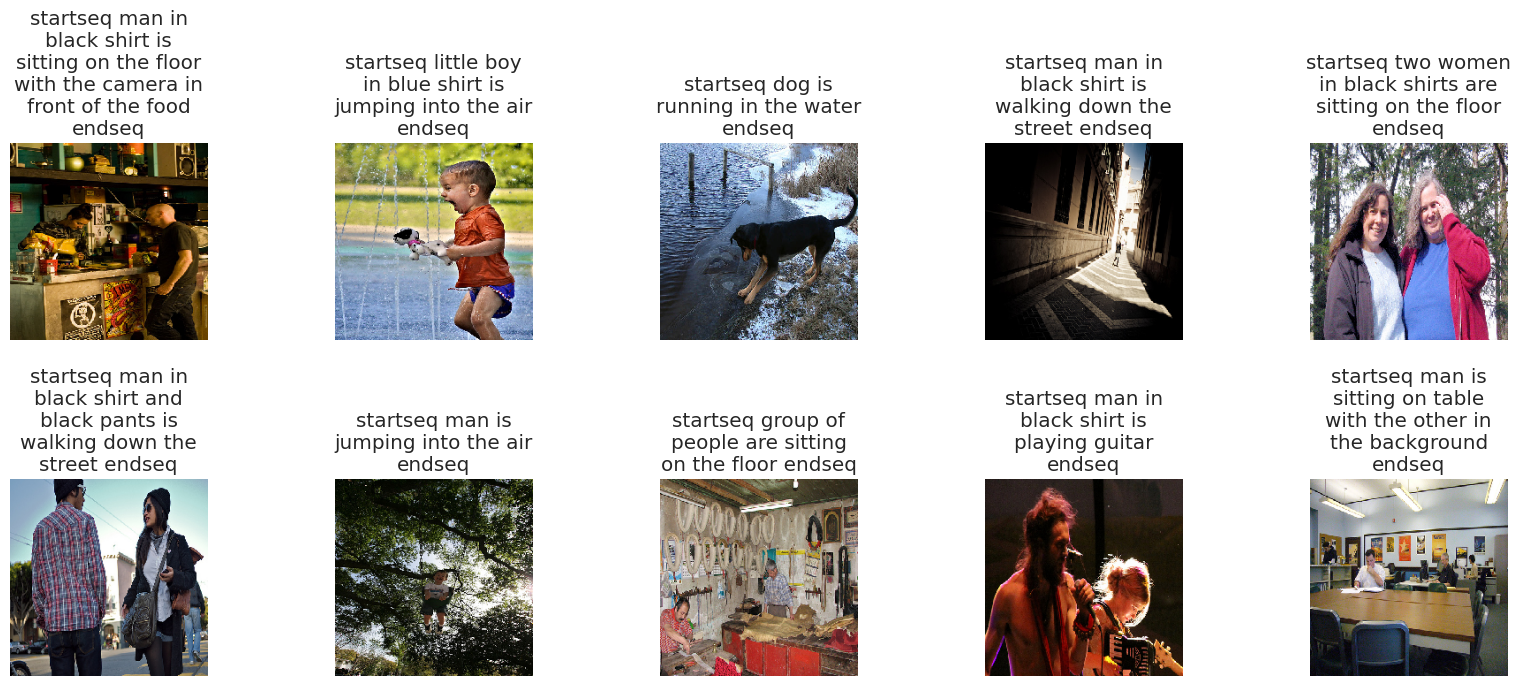

In [32]:
display_images(samples)

**What if ther is text in the image???**

In [33]:
!apt install tesseract-ocr libtesseract-dev
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libarchive-dev libleptonica-dev tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  libarchive-dev libleptonica-dev libtesseract-dev tesseract-ocr tesseract-ocr-eng
  tesseract-ocr-osd
0 upgraded, 6 newly installed, 0 to remove and 24 not upgraded.
Need to get 8,560 kB of archives.
After this operation, 31.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libarchive-dev amd64 3.6.0-1ubuntu1 [581 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libleptonica-dev amd64 1.82.0-3build1 [1,562 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libtesseract-dev amd64 4.1.1-2.1build1 [1,600 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:5 http://archive.ubunt

In [34]:
from PIL import Image
import pytesseract
from PIL import Image
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'  # Adjust path if needed

In [37]:
def predict_caption_for_new_image(image_filename, caption_model, tokenizer, max_length, feature_extractor):
    """
    Predicts a caption for a new image using a trained image captioning model.

    Args:
        image_filename (str): Path to the new image file.
        caption_model (keras.models.Model): Trained image captioning model.
        tokenizer (keras.preprocessing.text.Tokenizer): Tokenizer used for text preprocessing.
        max_length (int): Maximum length of generated captions.
        feature_extractor (keras.models.Model): Model for extracting image features.

    Returns:
        str: Predicted caption for the image.
    """

    # Load and preprocess the new image
    img_path = image_filename
    img_size = 224
    img = load_img(img_path, target_size=(img_size, img_size))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize

    # Extract features for the new image
    new_feature = feature_extractor.predict(img_array, verbose=0)

    # Store the extracted feature in a dictionary with the image name as key
    new_feature_dict = {os.path.basename(image_filename): new_feature}

    # Predict caption for the new image using the extracted feature
    caption = predict_caption(caption_model, image_filename, tokenizer, max_length, new_feature_dict)

    return caption


**What and where in the image??**

In [35]:
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')  # Adjust for your desired locale

'en_US.UTF-8'

In [36]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.1.0 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 43.2/78.2 GB disk)


In [41]:
from PIL import Image
from ultralytics import YOLO

# Load a pretrained YOLOv8n model
yolo_model = YOLO('yolov8n.pt')

100%|██████████| 6.23M/6.23M [00:00<00:00, 96.4MB/s]


In [43]:
model_2 = DenseNet201()
fe_2 = Model(inputs=model_2.input, outputs=model_2.layers[-2].output)


In [71]:
def predict_caption_and_extract_text(image_filename, caption_model, tokenizer, max_length, feature_extractor, reference = []):
    """
    Predicts a caption for a new image, extracts text if present, and returns image, caption, and text.

    Args:
        image_filename (str): Path to the new image file.
        caption_model (keras.models.Model): Trained image captioning model.
        tokenizer (keras.preprocessing.text.Tokenizer): Tokenizer used for text preprocessing.
        max_length (int): Maximum length of generated captions.
        feature_extractor (keras.models.Model): Model for extracting image features.

    Returns:
        tuple: (image, caption, text) or (image, None, text)
    """

    # Load image and extract text
    img = Image.open(image_filename)
    results = yolo_model(img)  # results list
    plt.figure(figsize=(10, 10))
    # Show the results
    for r in results:
          im_array = r.plot()  # plot a BGR numpy array of predictions
          im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
          plt.imshow(im)
          plt.show()
    text = pytesseract.image_to_string(img)
    caption = predict_caption_for_new_image(image_filename, caption_model, tokenizer, max_length, feature_extractor)
    # Calculate BLEU score
    bleu_score = None
    if references:
          bleu_score = sentence_bleu(references, caption)
          print("BLEU Score:", bleu_score)
          # Print and display/save results
    if len(text) > 5:
        print("Caption:", caption)
        print("Extracted Text:", text)
    else:
        print("Caption:", caption)


0: 448x640 2 persons, 5 ties, 8.6ms
Speed: 2.5ms preprocess, 8.6ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


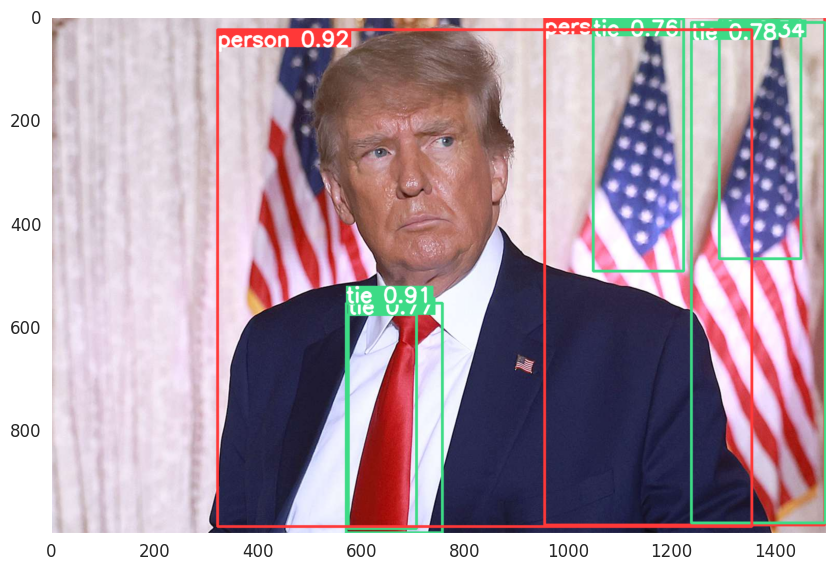

1/1 [==============================] - 0s 28ms/step
BLEU Score: 0.44728979279611525
Caption: startseq man in black shirt is sitting on the floor endseq


In [78]:
img_name = 'donald-trump-mar-a-lago-122322-1-660540beef294a2bb1f29f769284e1fc.jpg'
references = [
    "A man in blue suit and red tie looks a bit old.",
    "An old man with blone hair is a picture near american flags.",
    "A person wearing a blue suit, white shirt, red tie is looking serious"
]
result= predict_caption_and_extract_text(
    image_filename= img_name,
    caption_model=caption_model,
    tokenizer=tokenizer,
    max_length=30,
    feature_extractor=fe_2,
    reference = references
)


0: 640x512 1 dog, 10.0ms
Speed: 2.7ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)


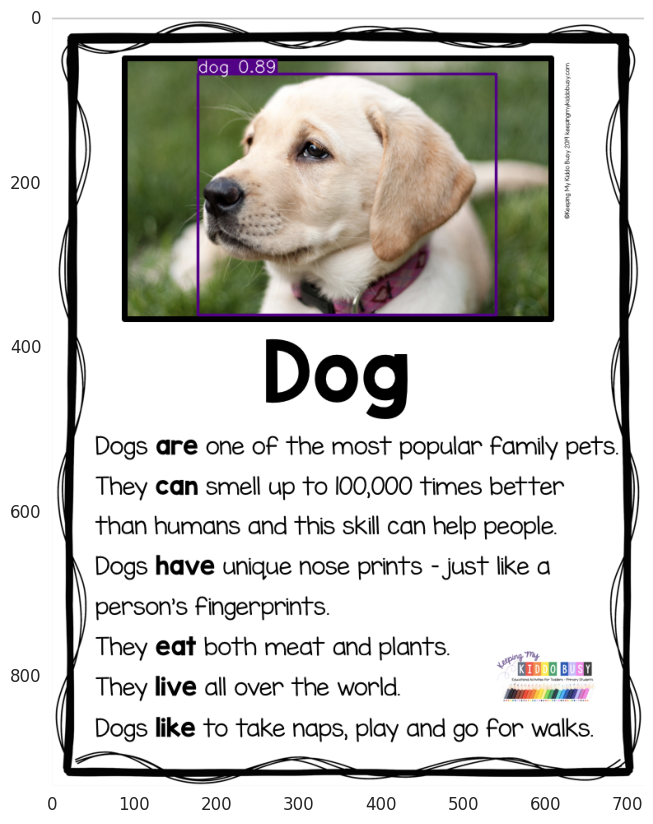

1/1 [==============================] - 0s 19ms/step
BLEU Score: 0.2783749596313413
Caption: startseq dog is running in the air endseq
Extracted Text: They can smell up to 100,000 times better
than humans and this skill can help people.

Dogs have unique nose prints - just like a
person's fingerprints.

They eat both meat and plants.
They live all over the world.

Dogs like to take naps, play and go for walks.
—_ _— - ~

ea
“ao Bo

 

—_—>

 

ee



In [86]:
img_name = 'dd0c6ae4d6d859a26e72716d85500ac3.png'
result= predict_caption_and_extract_text(
    image_filename= img_name,
    caption_model=caption_model,
    tokenizer=tokenizer,
    max_length=30,
    feature_extractor=fe_2
)


0: 384x640 1 dog, 1 laptop, 44.2ms
Speed: 3.2ms preprocess, 44.2ms inference, 9.6ms postprocess per image at shape (1, 3, 384, 640)


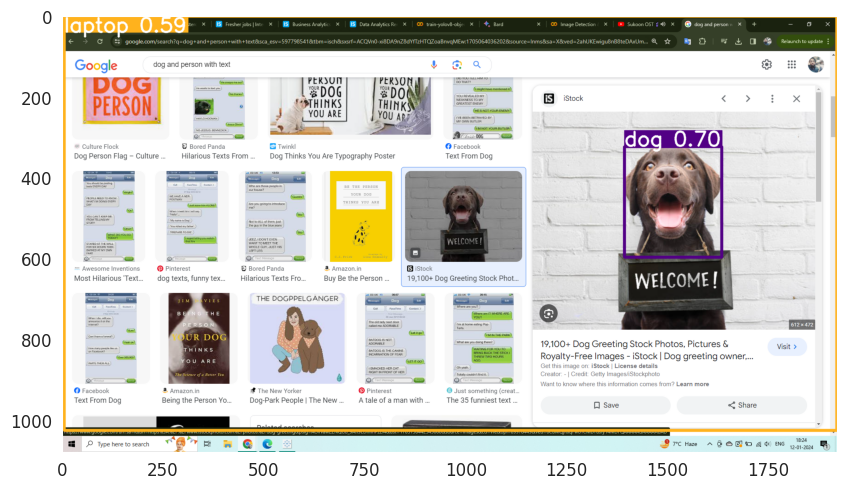

1/1 [==============================] - 0s 27ms/step
BLEU Score: 0.3202624446338799
Caption: startseq woman in black shirt is sitting on the floor with the camera of the camera is sitting on the floor endseq
Extracted Text: [Cee nes

aT Cees

 

 

 

Google dog and person with text mo 2
oO — reason vegans
PERSON s Ci; ie ay BB sox Coy ax

   

 

  

 

 

             

  

 

 

o 2 ata >
® Culture Flock © Bored Panda & twink! @ Facebook
Dog Person Flag ~ Culture ... Hilarious Texts From ... Dog Thinks You Are Typography Poster Text From Dog
"|
(Eases
Ea [Spenser
am (om
ae nti a \
a ‘Scone
a
(rasan) einai,
oo == o =.
Awesome Inventions @ Pinterest © Bored Panda & Amazon.in Bistock i
Most Hilarious ‘Text... dog texts, funny tex... Hilarious Texts Fro... Buy Be the Person ... 19,100+ Dog Greeting Stock Phot... oe vhs ke 0 | 3 | |
— co os = acon 5 aie = i
= CEE oa —z —. :
memes (egennere ©
en usa)
‘scree aca aelose 19,100+ Dog Greeting Stock Photos, Pictures & Visit >
eT or es Royalty-F

In [89]:
img_name = 'Screenshot (1340).png'
result= predict_caption_and_extract_text(
    image_filename= img_name,
    caption_model=caption_model,
    tokenizer=tokenizer,
    max_length=30,
    feature_extractor=fe_2
)


0: 384x640 1 tv, 25.8ms
Speed: 3.2ms preprocess, 25.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


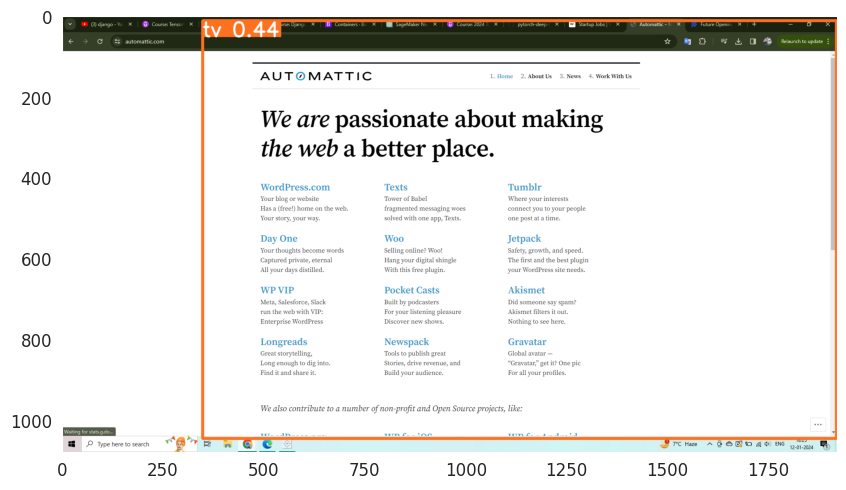

1/1 [==============================] - 0s 19ms/step
BLEU Score: 0.46784604636655597
Caption: startseq man in blue shirt is riding his bike on the ground endseq
Extracted Text:  

 

P Type here to search

 

AUTOMATTIC

1. Home 2. AboutUs 3. News 4. Work With Us

We are passionate about making

the web a better place.

WordPress.com

Your blog or website

Has a (free!) home on the web.
Your story, your way.

Day One

Your thoughts become words
Captured private, eternal

All your days distilled.

WP VIP

Meta, Salesforce, Slack
run the web with VIP:
Enterprise WordPress

Longreads

Great storytelling,

Long enough to dig into.
Find it and share it.

We also contribute to a number of non-profit and Open Source projects,

xr am --

wele =

 

Texts

Tower of Babel

fragmented messaging woes
solved with one app, Texts.

Woo

Selling online? Woo!
Hang your digital shingle
With this free plugin.

Pocket Casts

Built by podcasters
For your listening pleasure
Discover new shows.

Newspack

Too

In [88]:
img_name = 'Screenshot (1341).png'
result= predict_caption_and_extract_text(
    image_filename= img_name,
    caption_model=caption_model,
    tokenizer=tokenizer,
    max_length=30,
    feature_extractor=fe_2
)


0: 384x640 1 tv, 1 laptop, 14.2ms
Speed: 3.6ms preprocess, 14.2ms inference, 3.6ms postprocess per image at shape (1, 3, 384, 640)


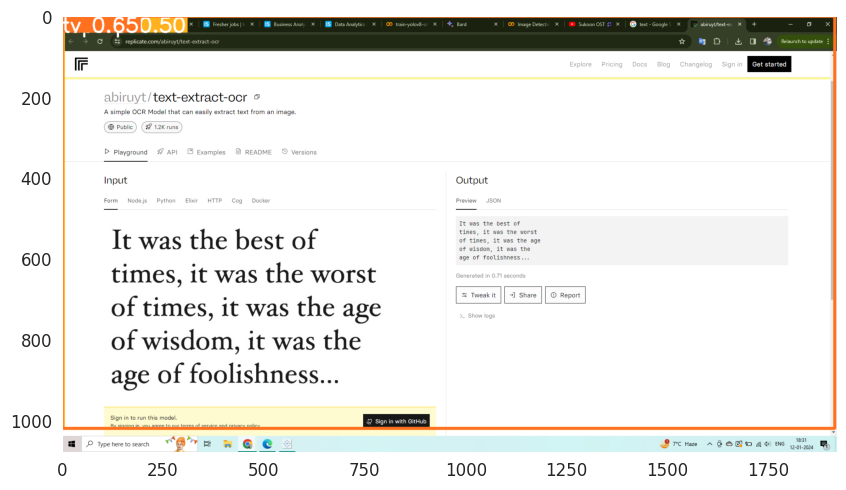

1/1 [==============================] - 0s 18ms/step
BLEU Score: 0.5049770130041792
Caption: startseq man in blue shirt is standing on the ground endseq
Extracted Text: ear eer ae a

Le ea a!

Blog Changelog Sign in [Eyer]

 

Ir Explore Pricing Docs

abiruyt/text-extract-ocr

A simple OCR Model that can easily extract text from an image.

(@ Public) (7 1.2K runs )

 

 

D Playground 7 AP! © Examples [ README © Versions
Input Output
Form Node.js | Python Elixir HTTP Cog Docker Preview JSON

 

 

It was the best of
times, it was the worst

It was the best of oF ies Hus the

age of foolishness...

times, it was the worst cna
of times, it was the age _
of wisdom, it was the

age of foolishness...

 

 

 

 

 

 

 

 

 

Sign in to run this model. © Super
By signing in, you agree to our terms of service end privacy policy

Aga
“qn = ra @ - Bie : 1831
‘6 aS w@@C@: Pre tae A FOND AY) NG yy

 

a 2 Type here to search

 

 



In [91]:
img_name = 'Screenshot (1344).png'
result= predict_caption_and_extract_text(
    image_filename= img_name,
    caption_model=caption_model,
    tokenizer=tokenizer,
    max_length=30,
    feature_extractor=fe_2
)

# Method-2

### Using Hugging Face LLM to predict the caption of the image

In [152]:
import torch
import requests
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration
from nltk.translate.bleu_score import sentence_bleu

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")    #getting llm model
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large", torch_dtype=torch.float16).to("cuda")

In [153]:


def generate_caption(img_path, processor, model, device="cuda"):
    """
    Generates a caption for an image using an unconditional image captioning model.

    Args:
        img_path (str): Path to the image file.
        processor (transformers.ImageTextProcessor): Processor for image and text.
        model (transformers.AutoModelForSeq2SeqLM): Image captioning model.
        device (str, optional): Device to use (e.g., "cpu" or "cuda"). Defaults to "cuda".

    Returns:
        str: The generated caption.
    """

    with Image.open(img_path) as raw_image:
        raw_image = raw_image.convert('RGB')

        inputs = processor(images=raw_image, return_tensors="pt").to(device)

        # Generate caption
        out = model.generate(**inputs)

        # Decode and return the caption
        caption = processor.decode(out[0], skip_special_tokens=True)
        return caption


In [154]:

import pytesseract
from IPython.display import display

def generate_caption_and_display_results(img_path, processor, model, device="cuda", desired_size=(500, 300)):
    """
    Generates a caption for an image, detects text (if present), resizes the image,
    and displays or saves the results.

    Args:
        img_path (str): Path to the image file.
        processor (transformers.ImageTextProcessor): Processor for image and text.
        model (transformers.AutoModelForSeq2SeqLM): Image captioning model.
        device (str, optional): Device to use. Defaults to "cuda".
        desired_size (tuple, optional): Desired size of the image as a tuple (width, height).
                                        Defaults to (500, 300).
    """

    with Image.open(img_path) as img:
        img = img.convert('RGB')

        # Resize the image
        img = img.resize(desired_size)  # Resize before other operations

        # Detect text
        text = pytesseract.image_to_string(img)

        # Generate caption
        inputs = processor(images=img, return_tensors="pt").to(device)
        out = model.generate(**inputs)
        caption = processor.decode(out[0], skip_special_tokens=True)

        # Print and display/save results
        if text:
            print("Caption:", caption)
            print("Extracted Text:", text)
            display(img)  # Display the resized image within the notebook
        else:
            print("Caption:", caption)
            display(img)  # Display the resized image within the notebook


In [157]:
import torch
from PIL import Image
import pytesseract
from IPython.display import display

def generate_caption_and_display_image(img_path, processor, model,yolo_model, device="cuda", desired_size=(500, 300),references=[]):
    """
    Generates a caption for an image, detects text (if present), resizes the image,
    and displays or saves the results.

    Args:
        img_path (str): Path to the image file.
        processor (transformers.ImageTextProcessor): Processor for image and text.
        model (transformers.AutoModelForSeq2SeqLM): Image captioning model.
        device (str, optional): Device to use. Defaults to "cuda".
        desired_size (tuple, optional): Desired size of the image as a tuple (width, height).
                                        Defaults to (500, 300).
    """

    with Image.open(img_path) as img:

        # Run inference on 'bus.jpg'
        results = yolo_model(img)  # results list

        plt.figure(figsize=(10, 10))
        # Show the results
        for r in results:
          im_array = r.plot()  # plot a BGR numpy array of predictions
          im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
          plt.imshow(im)
          plt.show()

        img = img.convert('RGB')

        # Resize the image
        img = img.resize(desired_size)  # Resize before other operations

        # Detect text
        text = pytesseract.image_to_string(img)
        # conditional image captioning
        text_1 = "This is a screenshot of"
        inputs = processor(img, text_1, return_tensors="pt").to("cuda", torch.float16)
        out = model.generate(**inputs)
        caption = processor.decode(out[0], skip_special_tokens=True)

        # Calculate BLEU score
        bleu_score = None
        if references:
          bleu_score = sentence_bleu(references, caption)
          print("BLEU Score:", bleu_score)
          # Print and display/save results
        if len(text) > 5:
            print("Caption:", caption)
            print("Extracted Text:", text)
        else:
            print("Caption:", caption)




0: 448x640 2 persons, 5 ties, 8.4ms
Speed: 2.8ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


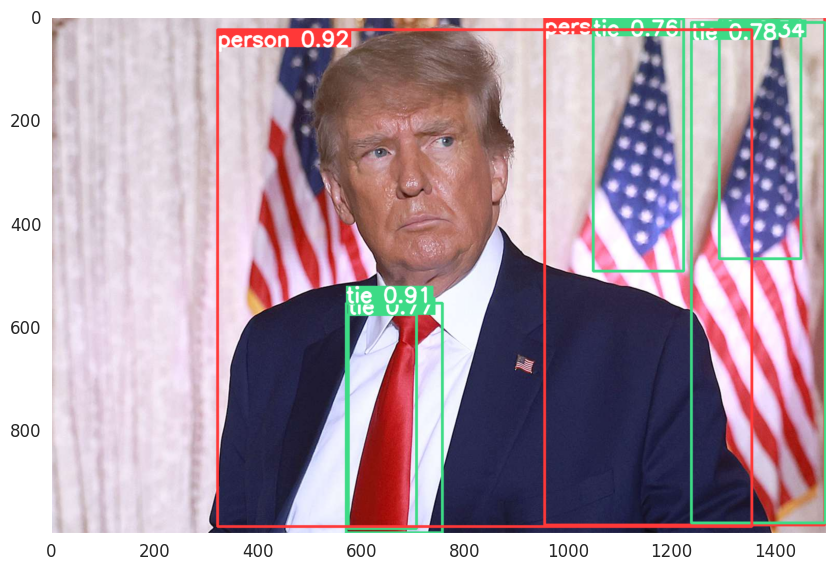

BLEU Score: 0.5924373883217677
Caption: this is a screenshot of a man in a suit and tie


In [158]:
img_path = '/content/donald-trump-mar-a-lago-122322-1-660540beef294a2bb1f29f769284e1fc.jpg'
references = [
    "A man in blue suit and red tie looks a bit old.",
    "An old man with blone hair is a picture near american flags.",
    "A person wearing a blue suit, white shirt, red tie is looking serious"
]
generate_caption_and_display_image(img_path, processor, model,yolo_model, device="cuda", desired_size=(500, 300), references=references)


0: 384x640 1 dog, 1 laptop, 13.0ms
Speed: 3.3ms preprocess, 13.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


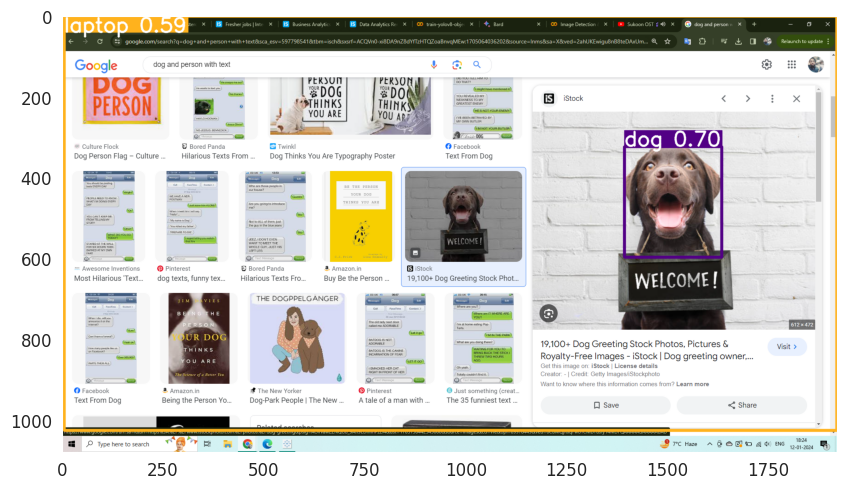

Caption: this is a screenshot of a dog with a sign in front of him


In [110]:
img_path = '/content/Screenshot (1340).png'

generate_caption_and_display_image(img_path, processor, model,yolo_model, device="cuda", desired_size=(500, 300))


0: 384x640 1 tv, 12.1ms
Speed: 3.1ms preprocess, 12.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


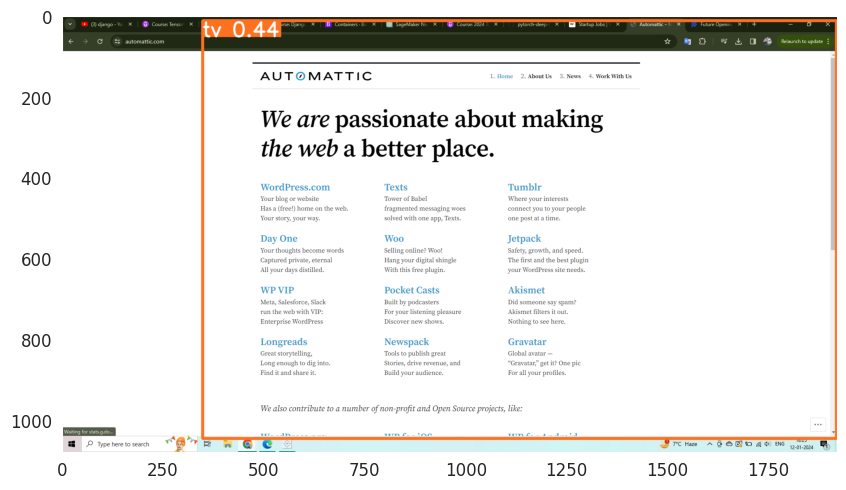

Caption: this is a screenshot of a website with a bunch of words
Extracted Text:  

 

We are passionate about making
the web a better place.

   

  

 

 



In [111]:
img_path = '/content/Screenshot (1341).png'

generate_caption_and_display_image(img_path, processor, model,yolo_model, device="cuda", desired_size=(500, 300))


0: 384x640 2 persons, 8.6ms
Speed: 2.2ms preprocess, 8.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


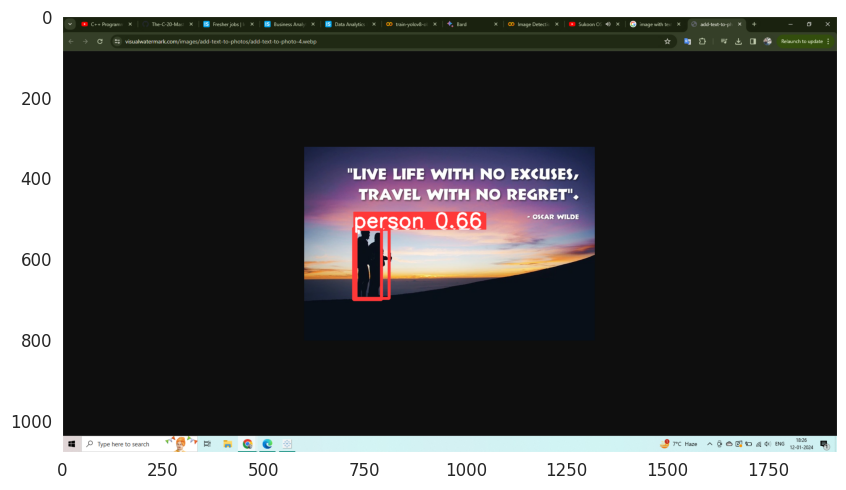

Caption: this is a screenshot of a picture of a couple walking together


In [112]:
img_path = '/content/Screenshot (1343).png'

generate_caption_and_display_image(img_path, processor, model,yolo_model, device="cuda", desired_size=(500, 300))


0: 384x640 1 tv, 1 laptop, 8.5ms
Speed: 2.3ms preprocess, 8.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


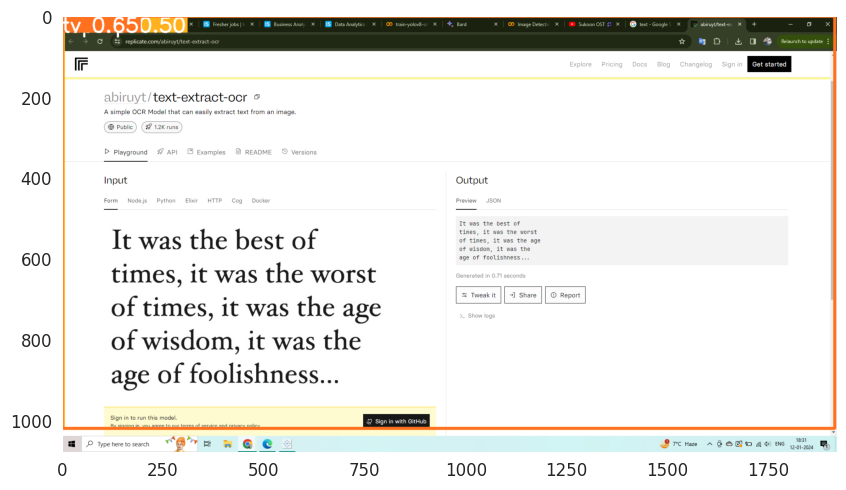

Caption: this is a screenshot of a website with a quote on it
Extracted Text: It was the best of
times, it was the worst
of times, it was the age
of wisdom, it was the
age of foolishness...

 

ween

 



In [113]:
img_path = '/content/Screenshot (1344).png'

generate_caption_and_display_image(img_path, processor, model,yolo_model, device="cuda", desired_size=(500, 300))